In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we use to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# train split, dev/validation split, and test split
# typically roughly 80%, 10% and 10%
def build_dataset(words):
    block_size = 3 # context length: how many characters do we use to predict the next one?
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [7]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [41]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [42]:
sum(p.nelement() for p in parameters)

11897

In [43]:
for p in parameters:
    p.requires_grad = True

In [11]:
# find a good learning rate:
# steps = 1000
# lre = torch.linspace(-3, 0, steps)
# lrs = 10 ** lre
# lrs

In [44]:
# lri = []
lossi = []
stepi = []

In [51]:

n_epochs = 50000
for i in range(n_epochs):
    # Forward pass
    # More organizedly (and efficient):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # much more efficient
    # if i % 1000 == 0:
        # print(f"Epoch {i} Loss: {loss}")
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())    

In [13]:
# loss.item()

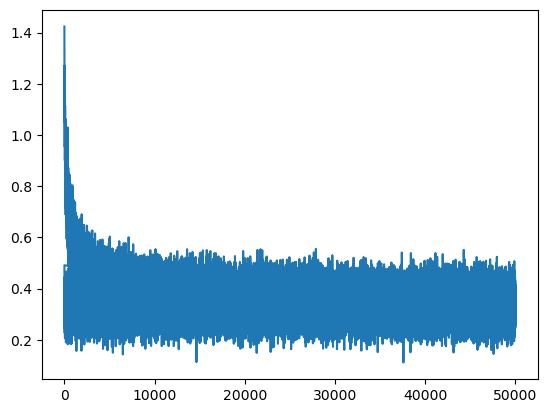

In [52]:
plt.plot(stepi, lossi)

In [53]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Dev Loss: {loss}")

Dev Loss: 2.1876473426818848


In [54]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Tr Loss: {loss}")

Tr Loss: 2.1667909622192383


In [56]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(f"Te Loss: {loss}")

Te Loss: 2.192763328552246


In [17]:
# plt.plot(lri, lossi)

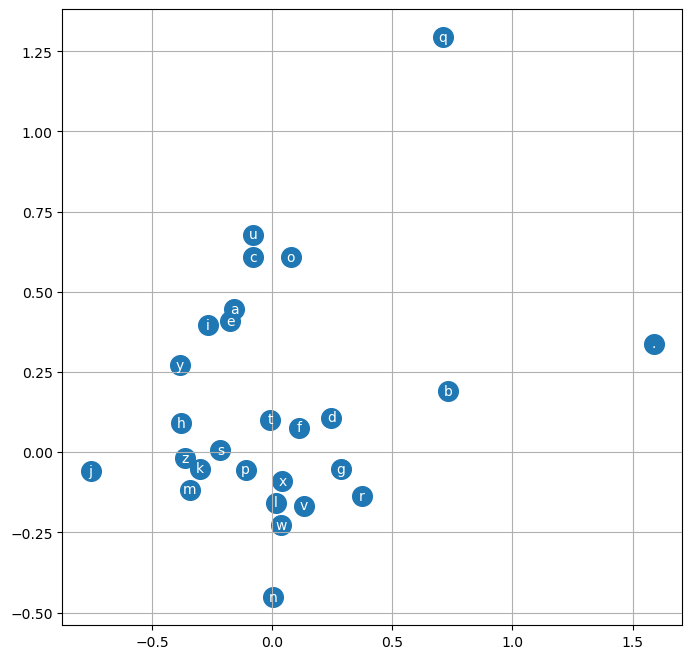

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [57]:
# Sample from model:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


mora.
mayah.
seel.
nihahla.
rethrusendrari.
azeer.
seli.
jemi.
jen.
eden.
sananara.
myzimoltrace.
shurtogahiries.
jacerenelipxethuor.
ube.
ged.
ryyah.
fael.
yuma.
miskolan.
